In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from torchdiffeq import odeint as torch_odeint
from scipy.integrate import odeint as sci_odeint

# Solving ODE with scipy solver

Here we are creating a minimal example of using scikit ODE solver

In [36]:
def ode(y, t, A, B, C):
    """Defining an ODE here"""
    dydt = (-A * y + B * t + C)
    return dydt

# time steps where we want to see the solution function
t = range(-50, 50, 1)

# ODE constants
A = .2
B = 10
C = 4

# solution
y = sci_odeint(
    func=ode,
    y0=1000,
    t=t,
    args=(A, B, C)
)

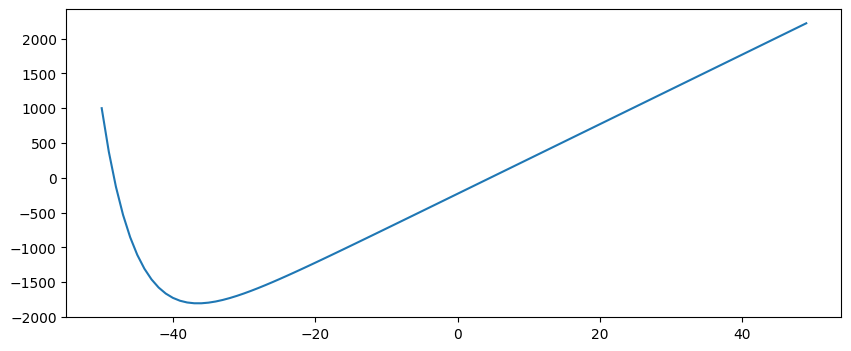

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(t, y)

# Solving ODE with torchdiffeq solver

Switching to ODE solver that takes in torch tensors of arbitrary dimensionality.

## 1d vector input to the solver

In [13]:
def ODE_1d(t, y):
    """ODE, solution to which is a 2d spiral"""
    A = .05
    B = .5
    return (-A * y**2  + B)

Text(0.5, 0, 'time steps')

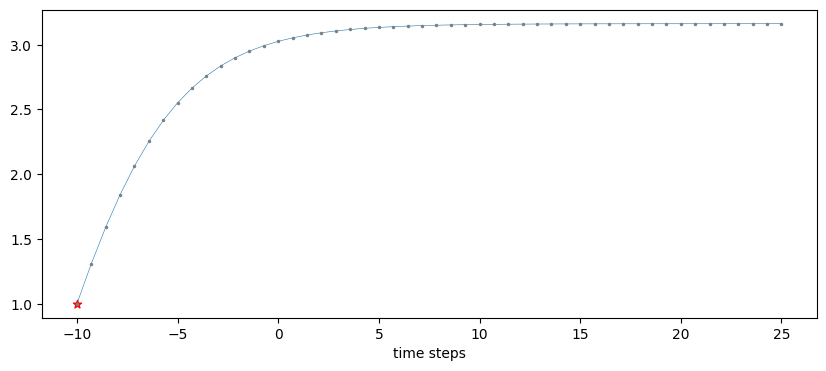

In [101]:
y0 = torch.tensor([1.])
time_range = torch.linspace(-10., 25., 50)
solution = torch_odeint(func=ODE_1d, y0=y0, t=time_range, 
                        atol=1e-5, rtol=1e-5)

plt.figure(figsize=(10, 4))
plt.scatter(x=[-10], y=[1.], color='red', marker='*') # drawing starting point
plt.plot(time_range, solution,
         marker='.', markerfacecolor='gray', markeredgecolor='gray', markersize=3,
         linewidth=.4)
plt.xlabel('time steps')

## 2d vector input to the solver

In [96]:
def ODE_2d(t, y):
    """ODE function"""
    coef = torch.tensor([[-5., .1], [.1, -5.]])
    return (y ** 2) @ coef

y0 = torch.tensor([[2., 0.]])
time_range = torch.linspace(-25., 25., 100)
solution = torch_odeint(func=ODE_2d, y0=y0, t=time_range, 
                        atol=1e-4, rtol=1e-4)

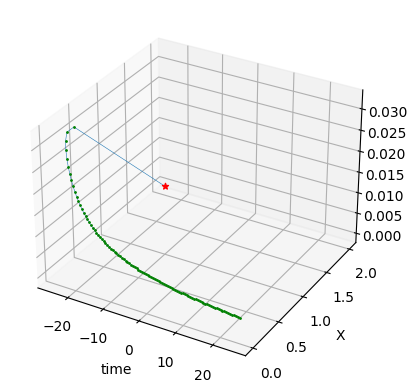

In [97]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(xs=[-25.], ys=[2.], zs=[0.], marker='*', color='red')
ax.plot(xs=time_range,
        ys=solution.detach().numpy()[:, 0][:, 0],
        zs=solution.detach().numpy()[:, 0][:, 1],
        marker='.', markerfacecolor='green', markeredgecolor='green', markersize=2, linewidth=.4)
ax.set_xlabel('time'); ax.set_ylabel('X');

## 2d spiral input to the solver

In [108]:
def ODE_2d(t, y):
    """ODE solution to which is a 3d spiral"""
    coef = torch.tensor([[-0.1, 2.0],   # matrix of coefficients that determine the spiral shape
                        [-2.0, -0.1]])
    ode = y**3 @ coef
    return ode

In [109]:
y0 = torch.tensor([[2., 0.]])       # starting point from which spiral is drawn
t = torch.linspace(-10., 50., 500)  # all time steps for which spiral is calculated

solution = torch_odeint(ODE_2d, y0=y0, t=t)

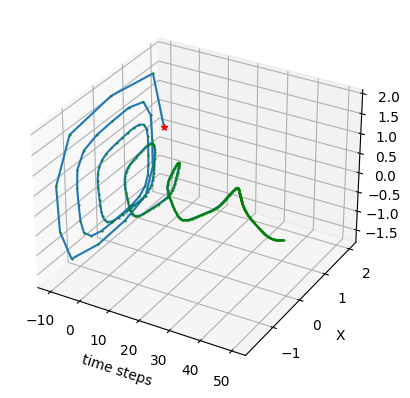

In [110]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(xs=[-10.], ys=[2], zs=[0], marker='*', color='red') # plotting starting point y0
ax.plot(xs=t,
        ys=solution.detach().numpy()[:, 0][:, 0],
        zs=solution.detach().numpy()[:, 0][:, 1],
        marker='.', markerfacecolor='green', markeredgecolor='green', markersize=1,)
ax.set_xlabel('time steps'); ax.set_ylabel('X');

Dimension of timesteps is only plotted to demonstrate the order in which solver reconstructed the original function. We see that the start is indeed from the y0 point provided (see red marker on the plot). We can redraw the last 2 dimensions only to see the spiral itself, i.e. the original function, solution of the parametrised ODE.

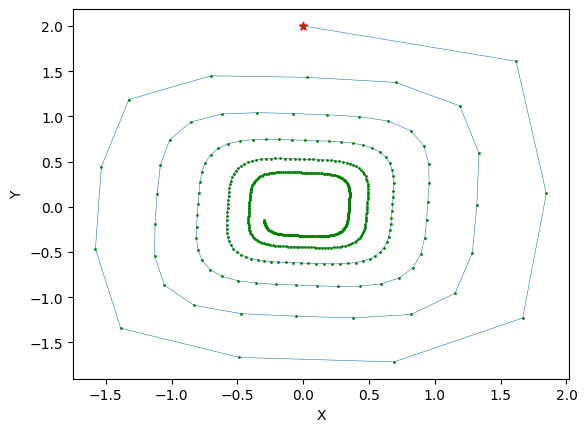

In [113]:
plt.scatter(x=[0], y=[2], marker='*', color='red') # plotting starting point y0
plt.plot(solution[:, 0][:, 1].detach().numpy(),
         solution[:, 0][:, 0].detach().numpy(),
         marker='.', markerfacecolor='green', markeredgecolor='green', markersize=2,
         linewidth=.4)
plt.xlabel('X')
plt.ylabel('Y');

# Using torchdiffeq solver in NN forward pass

This is an attempt to reproduce this example from the 2018 paper authors:
github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py

In [24]:
def ODE_2d(t, y):
    """ODE, solution to which is a spiral"""
    coef = torch.tensor([[-0.1, 2.0],   # matrix of coefficients that determine the spiral shape
                        [-2.0, -0.1]])
    ode = y**3 @ coef
    return ode

# some meta params
num_epochs = 10000
data_size = 1000
batch_time = 10
batch_size = 20

y0 = torch.tensor([[2., 0.]])           # starting point from which spiral is drawn
t = torch.linspace(0., 25., data_size)  # all time steps for which spiral is calculated

# getting the true vector which we will approximate
true_y = torch_odeint(ODE_2d, y0=y0, t=t, method='dopri5', atol=1e-3)

In [25]:
# TODO: batching needs to be simplified or removed completely
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [47]:
class ODEFunc(torch.nn.Module):
    """ with this network we aim to approximate ODE, i.e. dynamics rule with 
    which original function could be reconstructed step by step using computational solvers"""
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 256),
            torch.nn.Tanh(),
            torch.nn.Linear(256, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 2)
        )

    def forward(self, t, y):
        # in the example provided by the authors the ouput is raised to the power of 3
        # even though it reduces training time, it is not necessary. 
        # Through architecture and lr iteration, 
        # it is possible to find a network that successfully approximates differential equation.
        return self.layers(y) 

In [48]:
func = ODEFunc()
optimizer = torch.optim.Adam(func.parameters(), lr=5e-4)

Iter 9500 | Total Loss 0.382419


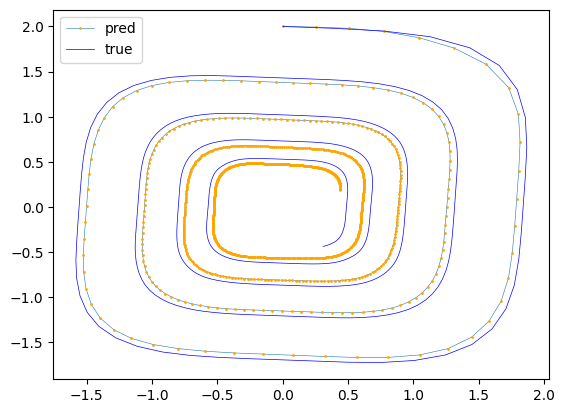

In [49]:
for iter in range(num_epochs):
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = torch_odeint(func, batch_y0, batch_t)
    loss = torch.nn.functional.l1_loss(input=pred_y, target=batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 500 == 0:
        clear_output()
        tes_pred_y = torch_odeint(func, y0, t)
        loss = torch.nn.functional.l1_loss(input=tes_pred_y, target=true_y)
        print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.detach().item()))

        
        plt.plot(tes_pred_y[:, 0][:, 1].detach().numpy(),
                 tes_pred_y[:, 0][:, 0].detach().numpy(),
                 marker='.', markerfacecolor='orange', markeredgecolor='orange', markersize=2,
                 linewidth=.4,
                 label='pred')

        plt.plot(true_y[:, 0][:, 1].detach().numpy(),
                 true_y[:, 0][:, 0].detach().numpy(),
                #  marker='.', markerfacecolor='green', markeredgecolor='green', markersize=2,
                 color='blue',
                 linewidth=.5,
                 label='true')
        plt.legend()
        plt.show()

So in essence by neural network we are approximating a rule that receives some value at time t and outputs next value at time t+1. That is, we are approximating the rule describing how original function changes with time. Or, in other words, we are approximating the differential equation using a neural network, hence the name of the concept -- neural differential equation. Further, we  pass this approximated rule to the ODE solver that reconstructs the original function step by step. We compare the output of the solver to the original function, find loss and backprop it to the network through solver.